# MadMiner Parton-Level Analysis for $W\gamma$:  Generation

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline
from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor

mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

process_tag= 'wgamma_1M'
madminerfile_save='data/madminer_wgamma.h5'
madminerfile_data='data/madminer_wgamma_observables_1M.h5'

## 1. Define parameter space

In [2]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)

17:19  
17:19  ------------------------------------------------------------
17:19  |                                                          |
17:19  |  MadMiner v2018.11.06                                    |
17:19  |                                                          |
17:19  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
17:19  |                                                          |
17:19  ------------------------------------------------------------
17:19  
17:19  Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
17:19  Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))


## 2. Define benchmark points (evaluation points for |M|^2)

17:19  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
17:19  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)
17:19  Optimizing basis for morphing
17:19  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
17:19  Added benchmark w: CWL2 = 20.00, CPWL2 = 0.00e+00)
17:19  Added benchmark morphing_basis_vector_2: CWL2 = -4.69e+01, CPWL2 = 27.54)
17:19  Added benchmark morphing_basis_vector_3: CWL2 = 21.00, CPWL2 = 46.69)
17:19  Added benchmark morphing_basis_vector_4: CWL2 = 32.29, CPWL2 = -4.64e+01)
17:19  Added benchmark morphing_basis_vector_5: CWL2 = -3.43e+01, CPWL2 = -3.61e+01)


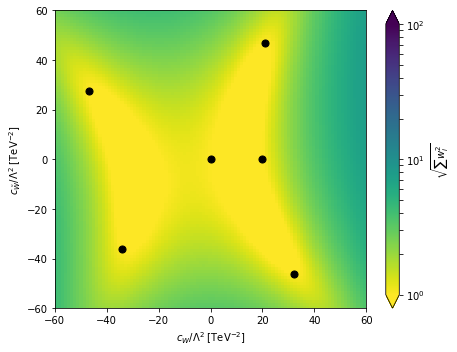

In [3]:
# By Hand
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w'
)

# Fill the others automaticially
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

#plot
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-60.,60),
    yrange=(-60.,60.)
)

## 3. Save settings and run MadGraph

In [4]:
# Setup HDF5 file
miner.save(madminerfile_save)

#Run MG
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/'+process_tag,
    proc_card_file='cards/proc_card_wgamma.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card_wgamma.dat',
    log_directory='logs/'+process_tag,
    initial_command='source ~/.bashrc'
)


17:19  Saving setup (including morphing) to data/madminer_wgamma_xxx.h5
17:19  Generating MadGraph process folder from cards/proc_card_wgamma.dat at ./mg_processes/wgamma_1M_xxx
17:19  Run 0
17:19    Sampling from benchmark: sm
17:19    Original run card:       cards/run_card_wgamma.dat
17:19    Original Pythia8 card:   cards/run_card_wgamma.dat
17:19    Copied run card:         ./mg_processes/wgamma_1M_xxx/madminer/cards/run_card_0.dat
17:19    Copied Pythia8 card:     None
17:19    Param card:              ./mg_processes/wgamma_1M_xxx/madminer/cards/param_card_0.dat
17:19    Reweight card:           ./mg_processes/wgamma_1M_xxx/madminer/cards/reweight_card_0.dat
17:19    Log file:                logs/wgamma_1M_xxx/run_0.log
17:19  Creating param and reweight cards in ./mg_processes/wgamma_1M_xxx/madminer/cards/param_card_0.dat, ./mg_processes/wgamma_1M_xxx/madminer/cards/reweight_card_0.dat
17:19  Starting MadGraph and Pythia in ./mg_processes/wgamma_1M_xxx


## 4. Extract Parton Level Observables / Weights 

### 4a) Interesting High level Observables

In [5]:
#initiate
lhep = LHEProcessor()
lhep.add_lhe_sample('mg_processes/'+process_tag+'/Events/run_01/unweighted_events.lhe.gz',sampling_benchmark="sm")
lhep.read_benchmark_names(madminerfile_save)

#define observables
lhep.add_observable('px_l', 'p[0].px')
lhep.add_observable('px_v', 'p[1].px')
lhep.add_observable('px_a', 'p[2].px')

lhep.add_observable('py_l', 'p[0].py')
lhep.add_observable('py_v', 'p[1].py')
lhep.add_observable('py_a', 'p[2].py')

lhep.add_observable('pz_l', 'p[0].pz')
lhep.add_observable('pz_v', 'p[1].pz')
lhep.add_observable('pz_a', 'p[2].pz')

lhep.add_observable('e_l', 'p[0].e')
lhep.add_observable('e_v', 'p[1].e')
lhep.add_observable('e_a', 'p[2].e')

lhep.add_observable('pt_l', 'p[0].pt')
lhep.add_observable('pt_v', 'p[1].pt')
lhep.add_observable('pt_a', 'p[2].pt')

lhep.add_observable('eta_l', 'p[0].eta')
lhep.add_observable('eta_v', 'p[1].eta')
lhep.add_observable('eta_a', 'p[2].eta')

lhep.add_observable('dphi_lv', 'p[0].deltaphi(p[1])')
lhep.add_observable('dphi_la', 'p[0].deltaphi(p[2])')
lhep.add_observable('dphi_va', 'p[1].deltaphi(p[2])')

lhep.add_observable('m_lv' , '(p[0] + p[1]).m')
lhep.add_observable('m_lva', '(p[0] + p[1] + p[2]).m')

#run
lhep.analyse_lhe_samples()
lhep.save(madminerfile_data, madminerfile_save)

18:57  Adding LHE sample at mg_processes/wgamma_1M_xxx/Events/run_01/unweighted_events.lhe.gz
18:57  Adding (not required) observable px_l = p[0].px
18:57  Adding (not required) observable px_v = p[1].px
18:57  Adding (not required) observable px_a = p[2].px
18:57  Adding (not required) observable py_l = p[0].py
18:57  Adding (not required) observable py_v = p[1].py
18:57  Adding (not required) observable py_a = p[2].py
18:57  Adding (not required) observable pz_l = p[0].pz
18:57  Adding (not required) observable pz_v = p[1].pz
18:57  Adding (not required) observable pz_a = p[2].pz
18:57  Adding (not required) observable e_l = p[0].e
18:57  Adding (not required) observable e_v = p[1].e
18:57  Adding (not required) observable e_a = p[2].e
18:57  Adding (not required) observable pt_l = p[0].pt
18:57  Adding (not required) observable pt_v = p[1].pt
18:57  Adding (not required) observable pt_a = p[2].pt
18:57  Adding (not required) observable eta_l = p[0].eta
18:57  Adding (not required) o

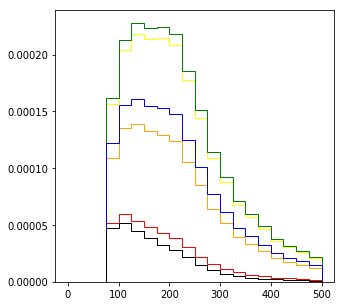

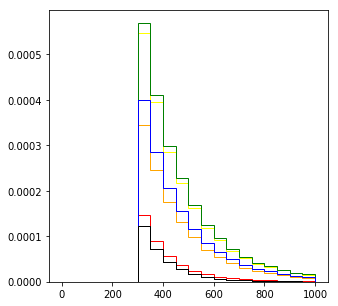

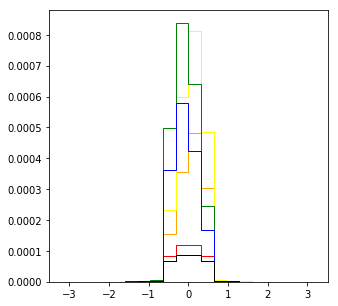

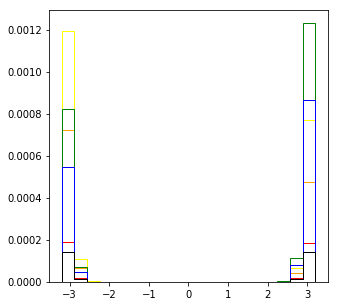

In [6]:
mycolors=["black","red","orange","yellow","green","blue","purple"]

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['pt_v'], range=(0.,500.), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['pt_v'], range=(0.,500.), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['pt_a'], range=(0.,1000.), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['pt_a'], range=(0.,1000.), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['dphi_lv'], range=(-3.2,3.2), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['dphi_lv'], range=(-3.2,3.2), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()

fig = plt.figure(figsize=(5,5))
for i, weights in enumerate(lhep.weights):
    plt.hist(lhep.observations['dphi_la'], range=(-3.2,3.2), bins=20, histtype='step', weights=weights,color=mycolors[i])
plt.hist(lhep.observations['dphi_la'], range=(-3.2,3.2), bins=20, histtype='step', weights=lhep.weights[0],color=mycolors[0])
plt.show()